In [127]:

%load_ext autoreload
from casadi import * 
import numpy as np
import matplotlib.pyplot as plt

from class_NMPC import NMPC
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1> Define problem parameters </h1>

In [128]:
%autoreload
Q = np.diag([120,   #x
            120,    #y
            120,    #z
            1e-2,   #phi
            1e-2,   #theta
            1,   #psi
            7e-1,   #vx
            1,      #vy
            10,      #vz
            1e-5,   #phi_dot
            1e-5,   #theta_dot
            10])   #psi_dot

R = np.diag([1, 1, 1, 1])* 0.06


<h1> Method 1 : Direct Multiple Shooting </h1>

In [129]:
#Define the DMS solver params
N_dms = 50 # number of control intervals to solve for
T_dms = 0.1 # time period in which to solve for the control intervals
Tf_dms = 15 # time period for the MPC to solve the problem
nlp_opt_dms = {'ipopt': {'print_level': 0, 'max_iter':1000}, 'print_time': 0}
method = "DMS"




Create solver instance and instantiate solve with the parameters

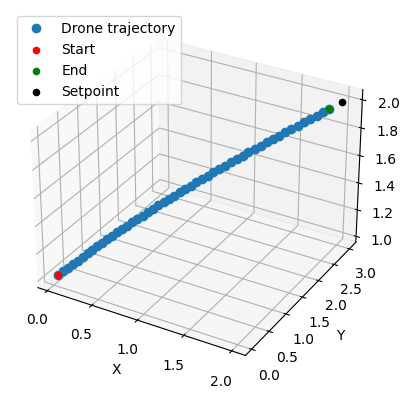

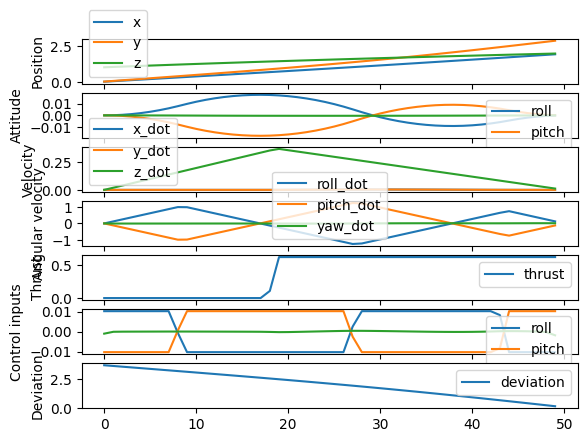

In [130]:
%autoreload
mpc = NMPC(Q, R, N_dms, T_dms, Tf_dms, nlpopts_dms=nlp_opt_dms)
x_init = [0,0,1]
x_desired =[2,3,2]
mpc.degree = None
mpc.method = method
mpc.solve_open_loop_and_plot(x_init, x_desired)

The above plot shows the solution of the solver, for a the current horizon length, from the start point to the desired endpoint. Here we see that the Final state has converged somewhat close to the final endpoint

<h1> Method 2 : Direct Collocation </h1>

In [131]:
# define the solver params
%autoreload
N_dc = 50 # number of control intervals to solve for
T_dc = 0.1 # time period in which to solve for the control intervals
Tf_dc = 15 # time period for the MPC to solve the problem
nlp_opt_dc = {'ipopt': {'print_level': 0, 'max_iter':1000}, 'print_time': 0}
method = "DC"
degree = 2



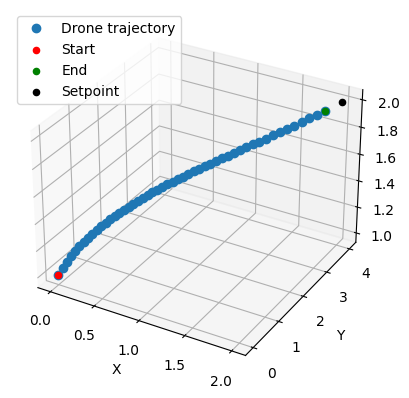

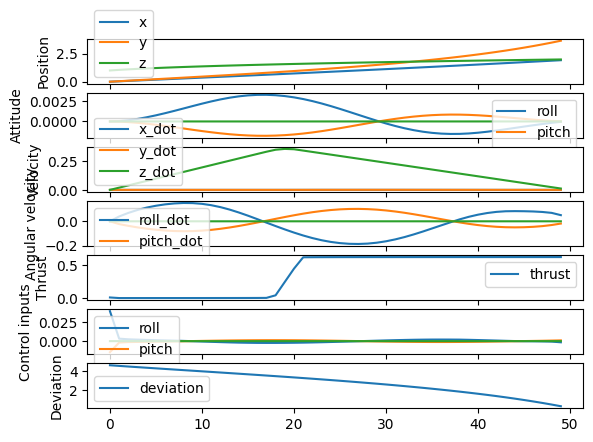

In [132]:
%autoreload
dc_mpc = NMPC(Q, R, N_dc, T_dc, Tf_dc, nlpopts_dc=nlp_opt_dc)
x_init = [0,0,1]
x_desired =[2,4,2]
dc_mpc.degree = degree
dc_mpc.method = method
dc_mpc.solve_open_loop_and_plot(x_init, x_desired)

In [133]:
dc_mpc.U_mpc

array([[ 9.33591464e-03,  3.99845528e-02, -1.46872618e-02,
         3.31896142e-06],
       [ 3.24611279e-04,  3.30587611e-03, -1.91091283e-03,
        -3.26653756e-07],
       [ 3.43667433e-04,  2.43683576e-03, -1.21817133e-03,
         1.17375037e-07],
       [ 3.65150877e-04,  2.02623151e-03, -1.06009550e-03,
         4.99510706e-08],
       [ 3.89537040e-04,  1.61365464e-03, -8.92348465e-04,
        -4.04641314e-08],
       [ 4.17439255e-04,  1.25856040e-03, -7.22536785e-04,
        -9.49443185e-08],
       [ 4.49657642e-04,  9.41086573e-04, -5.40464770e-04,
        -1.16154045e-07],
       [ 4.87267812e-04,  6.35056261e-04, -3.42405642e-04,
        -1.14672835e-07],
       [ 5.31732397e-04,  3.02339585e-04, -1.29686226e-04,
        -1.00411143e-07],
       [ 5.85092711e-04, -8.26698596e-05,  9.22335170e-05,
        -8.04990431e-08],
       [ 6.50299730e-04, -4.98914956e-04,  3.14868506e-04,
        -6.00703838e-08],
       [ 7.31771851e-04, -9.16149295e-04,  5.28582104e-04,
      

<h1> Closed Loop MPC </h1>

<h4> Method 1 : Direct multiple Shooting </h4>

The result has been saved in test_dms.mp4

In [201]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
%matplotlib inline
%autoreload
#Define the DMS solver params
N_dms = 10# number of control intervals to solve for
T_dms = 0.01 # time period in which to solve for the control intervals
Tf_dms = 15 # time period for the MPC to solve the problem
nlp_opt_dms = {'ipopt': {'print_level': 0, 'max_iter':50}, 'print_time': 0}
method = "DMS"
N_sim = 50000
min_dev = 0.01
stable_state_counter = 0
#create plot to plot the positions in real time

xs = []
ys = []
zs = []


x_init = [0,0,0]
x_desired = [0.75,0.75,0.75]
mpc_dms = NMPC(Q, R, N_dms, T_dms, Tf_dms, None, nlpopts_dms=nlp_opt_dms)
mpc_dms.set_values(x_init, x_desired)
mpc_dms.set_solver(method)
step = 0
control_input = []

while step < N_sim and stable_state_counter<30:
    mpc_dms.solve_for_next_state()
    mpc_dms.extract_next_state(step, False)
    # print(step)
    xs.append(mpc_dms.X_opt_current[0])
    ys.append(mpc_dms.X_opt_current[1])
    zs.append(mpc_dms.X_opt_current[2])
    print("current pose: {}".format(mpc_dms.X_opt_current[:3]))
    control_input.append(mpc_dms.control_input_to_drone())
    step += 1
    if np.linalg.norm(mpc_dms.X_opt_current[:3] - mpc_dms.x_desired[:3]) < min_dev:
        stable_state_counter += 1
print("The system has reached the desired state in {} steps".format(step))
print('Final state: {}'.format(mpc_dms.X_opt_current))
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')  
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# def animate(i):
#     ax.scatter(xs[:i], ys[:i], zs[:i], c='r', marker='o')
#     return ax
    
# ani = animation.FuncAnimation(fig, animate, frames=step, repeat = False)
# ani.save('test_dms.mp4', fps=step/60, extra_args=['-vcodec', 'libx264'])



current pose: [0.12396279 0.12396279 0.2863601 ]
current pose: [0.2251663  0.2251663  0.39715206]
current pose: [0.31200491 0.31200491 0.47352527]
current pose: [0.38811667 0.38811667 0.52914317]
current pose: [0.45126218 0.45126218 0.57292925]
current pose: [0.5056856  0.5056856  0.60629855]
current pose: [0.54781402 0.54781402 0.63329661]
current pose: [0.58288844 0.58288844 0.65432153]
current pose: [0.61046831 0.61046831 0.67180823]
current pose: [0.63188614 0.63188614 0.68553787]
current pose: [0.64990373 0.64990373 0.6967641 ]
current pose: [0.6656223  0.6656223  0.70592899]
current pose: [0.67876118 0.67876118 0.71347235]
current pose: [0.69049011 0.69049011 0.71984002]
current pose: [0.70079462 0.70079462 0.72494071]
current pose: [0.70900127 0.70900127 0.72917337]
current pose: [0.7158311  0.7158311  0.73275834]
current pose: [0.72146455 0.72146455 0.73574112]
current pose: [0.72619759 0.72619759 0.73819218]
current pose: [0.73012743 0.73012743 0.74021312]
current pose: [0.733

<h4> Method 2: Direct Collocation </h4>

The result has been saved in test_dc.mp4

In [202]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.animation as animation
# import time
# %matplotlib inline
# %autoreload
# #Define the DMS solver params
# N_dc = 5 # number of control intervals to solve for
# T_dc= 0.1 # time period in which to solve for the control intervals
# Tf_dc = 20 # time period for the MPC to solve the problem
# nlp_opt_dc = {'ipopt': {'print_level': 0, 'max_iter':50}, 'print_time': 0}
# method = "DC"
# degree = 2
# N_sim = 500
# min_dev = 0.01
# stable_state_counter = 0

# Q = np.diag([120,   #x
#             120,    #y
#             120,    #z
#             1e-2,   #phi
#             1e-2,   #theta
#             1,   #psi
#             7e-1,   #vx
#             1,      #vy
#             10,      #vz
#             1e-5,   #phi_dot
#             1e-5,   #theta_dot
#             10])   #psi_dot

# R = np.diag([1, 1, 1, 1])* 6
# #create plot to plot the positions in real time

# xs = []
# ys = []
# zs = []


# x_init = [0,0,0]
# x_desired = [0.75,0.75,0.75]
# mpc_dc = NMPC(Q, R, N_dc, T_dc, Tf_dc, nlpopts_dc=nlp_opt_dc)
# mpc_dc.set_values(x_init, x_desired)
# mpc_dc.set_solver(method, degree)
# print(mpc_dc.U_mpc.shape)
# step = 0
# control_input = []

# while step < N_sim and stable_state_counter<100:
#     start_time = time.time()
#     mpc_dc.solve_for_next_state()
#     end_time = time.time()
#     # print("time to solve for step ",step," : " , end_time-start_time)
#     mpc_dc.extract_next_state(step, False)
#     control_input.append(mpc_dc.control_input_to_drone())
#     # print(step)
#     xs.append(mpc_dc.X_opt_current[0])
#     ys.append(mpc_dc.X_opt_current[1])
#     zs.append(mpc_dc.X_opt_current[2])
#     print("current pose: {}".format(mpc_dc.X_opt_current[:3]))
    
#     step += 1
#     if np.linalg.norm(mpc_dc.X_opt_current[:3] - mpc_dc.x_desired[:3]) < min_dev:
#         stable_state_counter += 1
# print("The system has reached the desired state in {} steps".format(step))
# print('Final state: {}'.format(mpc_dc.X_opt_current))
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')  
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# def animate(i):
#     ax.scatter(xs[:i], ys[:i], zs[:i], c='r', marker='o')
#     return ax
    
# ani = animation.FuncAnimation(fig, animate, frames=step, repeat = False)
# ani.save('test_dc.mp4', fps=step/60, extra_args=['-vcodec', 'libx264'])

In [203]:
mpc_dms.X_mpc

array([[ 1.23962788e-01,  1.23962788e-01,  2.86360098e-01, ...,
         6.14264616e-02, -6.11165724e-02, -3.03525313e-07],
       [ 2.25166300e-01,  2.25166300e-01,  3.97152064e-01, ...,
         1.05761028e-01, -1.05227758e-01, -7.92778015e-07],
       [ 3.12004912e-01,  3.12004912e-01,  4.73525267e-01, ...,
         6.64591505e-02, -6.61245299e-02, -1.04876152e-06],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [204]:
mpc_dms.U_mpc[:442, :]

array([[ 2.11941817e-09,  1.01794089e-02, -1.01793318e-02,
        -8.98662805e-08],
       [ 2.12384725e-09,  7.34699139e-03, -7.34698267e-03,
        -1.49133194e-07],
       [ 8.18744997e-09, -6.51298926e-03,  6.51287732e-03,
        -8.12021080e-08],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [205]:
mpc_dms.U_mpc.shape

(15000, 4)

In [206]:
# round off all the values of control_input to the 3rd decimal place

for i in range(len(control_input)):
    for j in range(len(control_input[i])):
        control_input[i][j] = round(control_input[i][j], 3)

len(control_input[1])

4

In [207]:
# save the control_input to a text file, with each row representing the control input for each step

with open('control_input_dms.txt', 'w') as f:
    for item in control_input:
        f.write("%s " % item[0])
        f.write("%s " % item[1])
        f.write("%s " % item[2])
        f.write("%s " % item[3])

In [208]:
def extract_control_input():
    control_input = np.loadtxt('control_input_dms.txt')
    control_input = control_input.reshape(step,4)
    #make the 4th column an integer without decimal points
    control_input[:,3] = control_input[:,3].astype(numpy.int64)
    return control_input

b = extract_control_input()
b


array([[ 2.0000e-03, -2.0000e-03, -0.0000e+00,  1.0001e+04],
       [ 7.0000e-03, -7.0000e-03, -0.0000e+00,  1.0001e+04],
       [ 1.1000e-02, -1.1000e-02, -0.0000e+00,  1.0001e+04],
       [ 1.4000e-02, -1.4000e-02, -0.0000e+00,  1.0001e+04],
       [ 1.6000e-02, -1.6000e-02, -0.0000e+00,  1.0001e+04],
       [ 1.6000e-02, -1.6000e-02, -0.0000e+00,  2.7575e+04],
       [ 1.5000e-02, -1.5000e-02, -0.0000e+00,  4.1172e+04],
       [ 1.4000e-02, -1.4000e-02, -0.0000e+00,  4.1172e+04],
       [ 1.2000e-02, -1.2000e-02, -0.0000e+00,  4.1172e+04],
       [ 1.1000e-02, -1.1000e-02, -0.0000e+00,  4.1172e+04],
       [ 1.0000e-02, -9.0000e-03, -0.0000e+00,  4.1172e+04],
       [ 8.0000e-03, -8.0000e-03, -0.0000e+00,  4.1172e+04],
       [ 7.0000e-03, -7.0000e-03, -0.0000e+00,  4.1172e+04],
       [ 6.0000e-03, -6.0000e-03, -0.0000e+00,  4.1172e+04],
       [ 5.0000e-03, -5.0000e-03, -0.0000e+00,  4.1172e+04],
       [ 4.0000e-03, -4.0000e-03, -0.0000e+00,  4.1172e+04],
       [ 3.0000e-03, -3.

In [209]:
sequence = [
    (0, 0, 0.7),
    (-0.7, 0, 0.7),
    (0, 0, 0.7),
    (0, 0, 0.2),
]

In [210]:
mpc_dms.X_mpc.shape

(15001, 12)

In [211]:
# extract the state x,y and z from the X_mpc and save it to a text file

def save_position():
    position = []
    for i in range(step):
        position.append((mpc_dms.X_mpc[i,0], mpc_dms.X_mpc[i,1], mpc_dms.X_mpc[i,2]))
    
    with open('position.txt', 'w') as f:
        for item in position:
            f.write("%s " % item[0])
            f.write("%s " % item[1])
            f.write("%s " % item[2])
    

save_position()

In [212]:
def extract_position():
    position = np.loadtxt('position.txt')
    position = position.reshape(step,3)
    return position.tolist()

position = extract_position()
position

[[0.123962787873131, 0.12396278787296246, 0.28636009792607997],
 [0.2251663000158662, 0.2251663000052321, 0.3971520641196578],
 [0.31200491186612156, 0.3120049118277683, 0.4735252668178646],
 [0.388116673260728, 0.38811667321096927, 0.5291431707799024],
 [0.45126218129624074, 0.4512621812634705, 0.572929251704859],
 [0.5056855977602649, 0.5056855976724814, 0.606298553666586],
 [0.5478140197071508, 0.5478140196655301, 0.633296613682513],
 [0.5828884365979168, 0.5828884365204278, 0.6543215268412655],
 [0.6104683061663941, 0.6104683060648266, 0.6718082339002248],
 [0.6318861440021412, 0.6318861439248814, 0.6855378724960176],
 [0.6499037271755462, 0.6499037271185516, 0.696764100717292],
 [0.6656222975083214, 0.6656222974574231, 0.7059289930275754],
 [0.6787611846348756, 0.6787611845802181, 0.7134723500046413],
 [0.6904901116589378, 0.6904901116158156, 0.7198400211704961],
 [0.7007946195386806, 0.7007946195978789, 0.7249407130473221],
 [0.7090012663933695, 0.709001266452629, 0.7291733726145